In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

<center><img src='./images/features.png'/></center>

In [51]:
pd.set_option('display.max_rows', 50)
df = pd.read_csv('./csv/train.csv')

In [52]:
# Attention count est une combinaison linéaire de registered et casual ; on peut modéliser séparément registered et casual et ajouter les deux résultats
(df['count'] == df['registered'] + df['casual']).value_counts()

True    10886
dtype: int64

## Données aberrantes

<AxesSubplot:xlabel='atemp', ylabel='temp'>

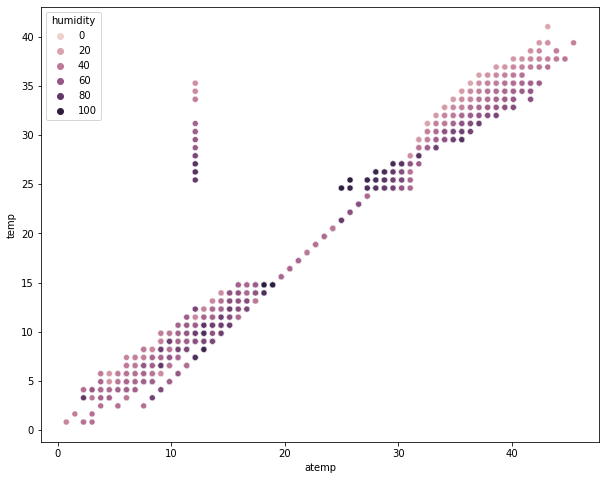

In [53]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='atemp', y='temp', hue='humidity', data=df)

In [54]:
# des données aberrantes à supprimer
df = df[~((df['temp'] > 20) & (df['atemp'] < 18))]

## Création des colonnes dates, months, hours

In [55]:
df['dates'] = pd.to_datetime(df['datetime']).dt.date
df['months'] = pd.to_datetime(df['datetime']).dt.month
df['hours'] = pd.to_datetime(df['datetime']).dt.hour

## Création de week_days

In [56]:
# samedi : 2011-01-01 (= 6)
df['days'] = (df['dates'] - df['dates'].min()).dt.days + 6
df['week_days'] = (df['days'] % 7)
df.loc[df['week_days'] == 0, 'week_days'] = 7
# df = df.drop('days', axis=1)

## Création de la colonne inconfort

<center><img src='./images/heat_index.png' /></center>

<center><img src='./images/heat_index_formula.png' /></center>

<center><img src='./images/heat_index_farenheit.png' /></center>

In [57]:
# Heat index (indice de chaleur) ; en degré celsius
c1 = -42.379
c2 = 2.04901523
c3 = 10.14333127
c4 = -0.22475541
c5 = -6.83783e-3
c6 = -5.481717e-2
c7 = 1.22874e-3
c8 = 8.5282e-4
c9 = -1.99e-6
T = 1.8*df['temp']+32
R = df['humidity']
df['HI'] = c1 + c2*T + c3*R + c4*T*R + c5*pow(T,2) + c6*pow(R,2) + c7*pow(T,2)*R + c8*T*pow(R,2) + c9*pow(T,2)*pow(R,2)
# Reconversion de HI en degrés celsius
df['HI'] = (df['HI'] - 32)*(5/9)
# HI = temp pour des températures inférieures à 14°C d'après les informations trouvées sur internet
df.loc[df['temp'] < 14, 'HI'] = df['temp']

## Renommage des saisons (1: printemps, 2: été, 3: automne, 4: hiver)

In [58]:
years= ['2010', '2011', '2012']
spring = ['03-21', '06-21']
summer = ['06-21', '09-21']
fall = ['09-21', '12-21']
winter = ['12-21', '03-21']
seasons = [spring, summer, fall, winter]
for year in years:
    compteur = 0
    for season in seasons:
        compteur += 1
        start = year + '-' + season[0]
        if season[1] != '03-21':
            end = year + '-' + season[1]
        else:
            end = str(int(year)+1) + '-' + str(season[1])
        df.loc[((df['dates'] >= pd.to_datetime(start)) & (df['dates'] < pd.to_datetime(end))), 'season'] = compteur

C:\Anaconda\envs\mv\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [59]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,months,hours,days,week_days,HI
count,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000,10862.000000
mean,2.494660,0.028632,0.680169,1.418523,20.210033,23.680571,61.897072,12.793427,35.965016,155.374333,191.339348,6.518229,11.541705,365.249033,4.011784,22.634122
std,1.117084,0.166777,0.466432,0.633837,7.785999,8.466574,19.249827,8.164335,49.950694,150.914014,180.994071,3.447475,6.915824,210.451467,2.006262,8.793808
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000,1.000000,0.820000
25%,1.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,4.000000,6.000000,188.000000,2.000000,13.940000
50%,2.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,7.000000,12.000000,371.000000,4.000000,24.816105
75%,3.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,222.000000,283.000000,10.000000,18.000000,541.000000,6.000000,28.231963
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,12.000000,23.000000,724.000000,7.000000,44.598524


## Séparation du jeu d'entraînement et de test

In [60]:
df_train = df[df['datetime'] < "2012-09-01"]
df_test = df[df['datetime'] >= "2012-09-01"]

## Analyse : count en fonction des autres variables

### La cible : count

<AxesSubplot:xlabel='count', ylabel='Count'>

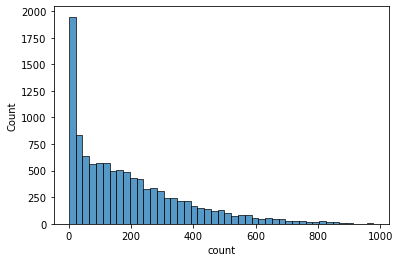

In [61]:
sns.histplot(df['count'])

## On étudie ensemble count, registered et casual en fonction des autres paramètres

In [62]:
def custom_barplot(df,x):
    count_x = df_train.groupby(x)['count'].sum().reset_index()
    registered_x = df_train.groupby(x)['registered'].sum().reset_index()
    casual_x = df_train.groupby(x)['casual'].sum().reset_index()
    fig, axes = plt.subplots(3,1,figsize=(15,12))
    ax = sns.barplot(ax=axes[0], x=count_x[x], y=count_x['count'], data=count_x)
    ax.set(xlabel=x,ylabel='count')
    ax.set(title='Nombre de vélos empruntés en fonction de ' + x)
    ax = sns.barplot(ax=axes[1], x=registered_x[x], y=registered_x['registered'], data=registered_x)
    ax.set(xlabel=x,ylabel='registered')
    ax.set(title='Nombre de vélos empruntés par des personnes abonnées en fonction de ' + x)
    ax = sns.barplot(ax=axes[2], x=casual_x[x], y=casual_x['casual'], data=casual_x)
    ax.set(xlabel=x,ylabel='casual')
    ax.set(title='Nombre de vélos empruntés par des personnes non-abonnées en fonction de ' + x)

def custom_boxplot(df,x):
    count_x = df_train.groupby(x)['count'].sum().reset_index()
    registered_x = df_train.groupby(x)['registered'].sum().reset_index()
    casual_x = df_train.groupby(x)['casual'].sum().reset_index()
    fig, axes = plt.subplots(3,1,figsize=(15,12))
    ax = sns.boxplot(ax=axes[0], x=count_x[x], y=count_x['count'], data=count_x, palette=["r"], showmeans=True)
    ax.set(xlabel=x,ylabel='count')
    ax.set(title='Nombre de vélos empruntés en fonction de ' + x)
    ax = sns.boxplot(ax=axes[1], x=registered_x[x], y=registered_x['registered'], data=registered_x, palette=["r"], showmeans=True)
    ax.set(xlabel=x,ylabel='registered')
    ax.set(title='Nombre de vélos empruntés par des personnes abonnées en fonction de ' + x)
    ax = sns.boxplot(ax=axes[2], x=casual_x[x], y=casual_x['casual'], data=casual_x, palette=["r"], showmeans=True)
    ax.set(xlabel=x,ylabel='casual')
    ax.set(title='Nombre de vélos empruntés par des personnes non-abonnées en fonction de ' + x)

### Hours

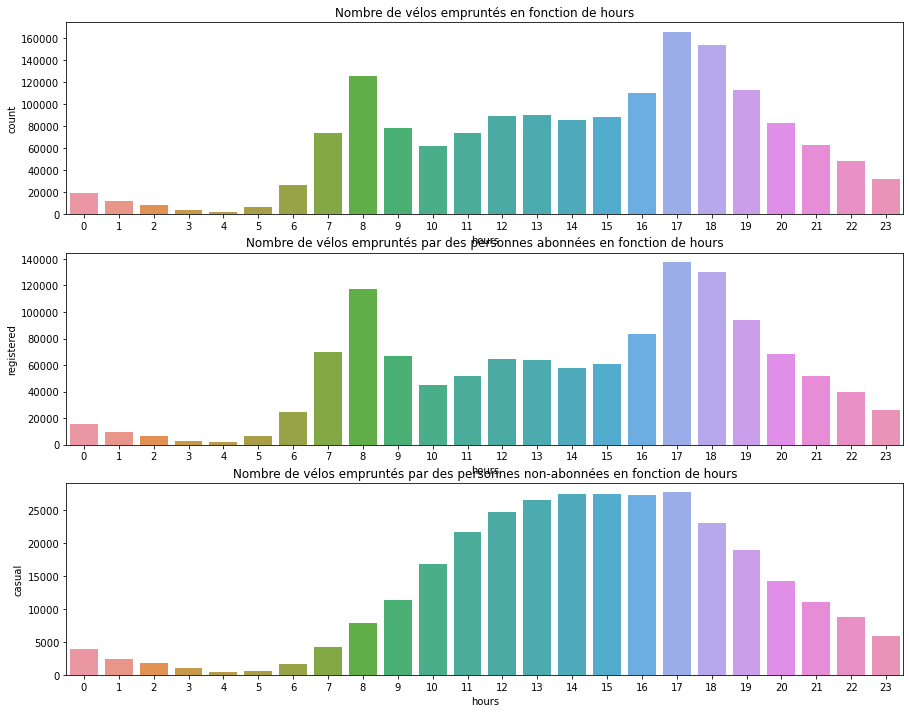

In [63]:
custom_barplot(df_train,'hours')

### Months

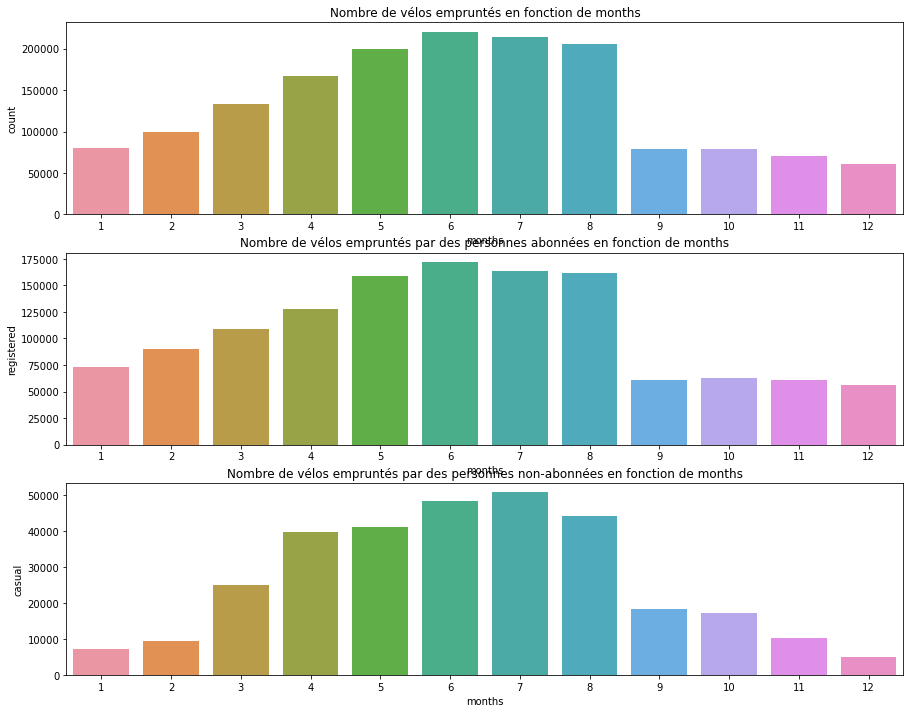

In [64]:
custom_barplot(df_train,'months')

### Season

In [65]:
def df_prop_transform(df_train,col):
    col_count_sum = df_train.groupby(col)['count'].sum().sum()
    col_count_prop = (df_train.groupby(col)['count'].sum()/col_count_sum).reset_index()
    col_registered_sum = df_train.groupby(col)['registered'].sum().sum()
    col_registered_prop = (df_train.groupby(col)['registered'].sum()/col_registered_sum).reset_index()
    col_casual_sum = df_train.groupby(col)['casual'].sum().sum()
    col_casual_prop = (df_train.groupby(col)['casual'].sum()/col_casual_sum).reset_index()

    col_count_all = col_count_prop.join(col_registered_prop['registered']).join(col_casual_prop['casual'])
    return pd.melt(col_count_all, id_vars=col, var_name="count", value_name="proportion")

<AxesSubplot:xlabel='season', ylabel='proportion'>

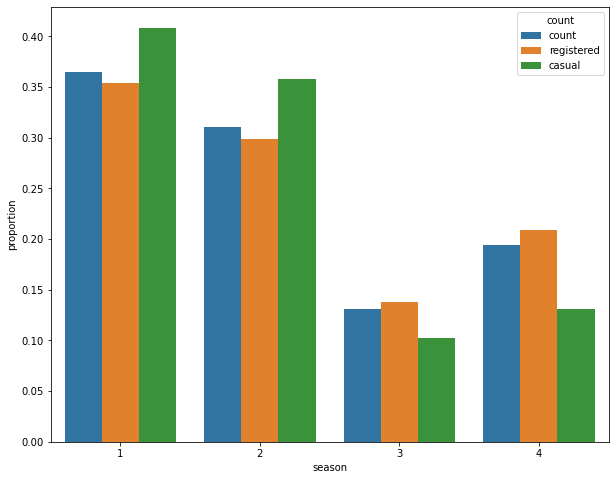

In [66]:
season_count_all = df_prop_transform(df_train,'season')
plt.figure(figsize=(10,8))
sns.barplot(x='season', y='proportion', hue='count', data=season_count_all)

### holiday

<AxesSubplot:xlabel='holiday', ylabel='proportion'>

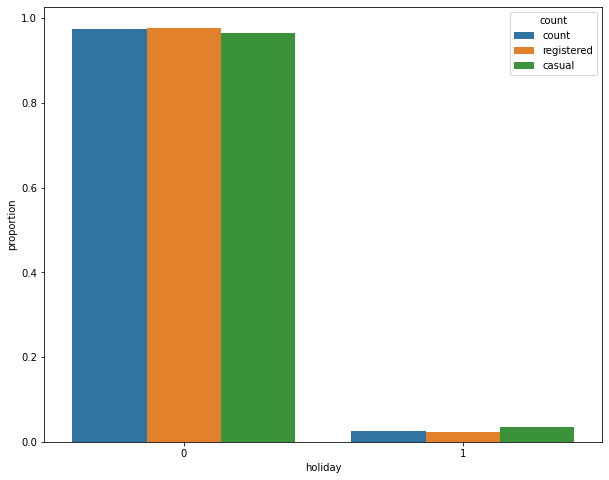

In [67]:
holiday_count_plot = df_prop_transform(df_train,'holiday')
plt.figure(figsize=(10,8))
sns.barplot(x='holiday', y='proportion', hue='count', data=holiday_count_plot)

### workingday

<AxesSubplot:xlabel='workingday', ylabel='proportion'>

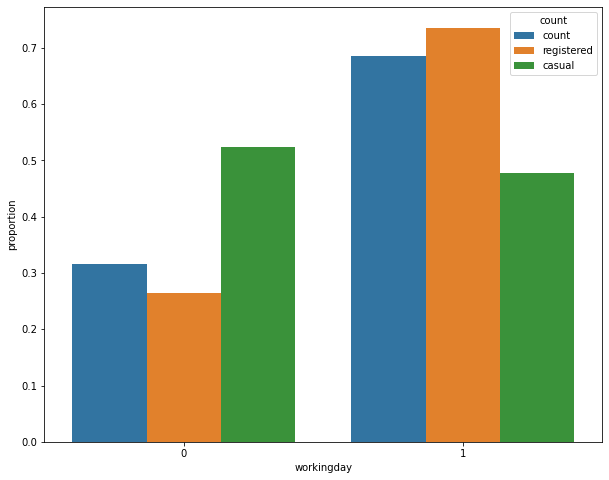

In [68]:
workingday_count_plot = df_prop_transform(df_train,'workingday')
plt.figure(figsize=(10,8))
sns.barplot(x='workingday', y='proportion', hue='count', data=workingday_count_plot)

### weather

<AxesSubplot:xlabel='weather', ylabel='proportion'>

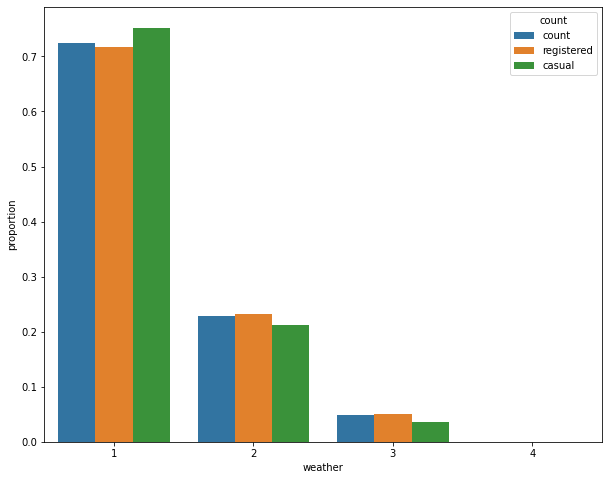

In [69]:
weather_count_plot = df_prop_transform(df_train,'weather')
plt.figure(figsize=(10,8))
sns.barplot(x='weather', y='proportion', hue='count', data=weather_count_plot)

### temp

In [70]:
def mean_cut(df,x,y, intervalle):
    moyenne_x = []
    moyenne_y = []
    intervalle = intervalle
    nb = math.ceil(max(df[x])/intervalle)
    for i in range(1, nb):
        moyenne_x.append(df[(df[x] > intervalle*(i-1)) & (df[x] < intervalle*(i))][x].mean())
        moyenne_y.append(df[(df[x] > intervalle*(i-1)) & (df[x] < intervalle*(i))][y].mean())
    moyenne_x =[moy for moy in moyenne_x if str(moy) != 'nan']
    moyenne_y =[moy for moy in moyenne_y if str(moy) != 'nan']

    moyenne_x = pd.DataFrame(moyenne_x).rename(columns={0:'moyenne_' + x}).round(decimals = 1)
    moyenne_y = pd.DataFrame(moyenne_y).rename(columns={0:'moyenne_' + y}).round(decimals = 1)

    return moyenne_x.join(moyenne_y)

def reduce_xticks_number(ax):
    for index, label in enumerate(ax.get_xticklabels()):
        if index % 4 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

In [71]:
temp_count = mean_cut(df_train,'temp','count',1)
temp_registered = mean_cut(df_train,'temp','registered',1)
temp_casual = mean_cut(df_train,'temp','casual',1)

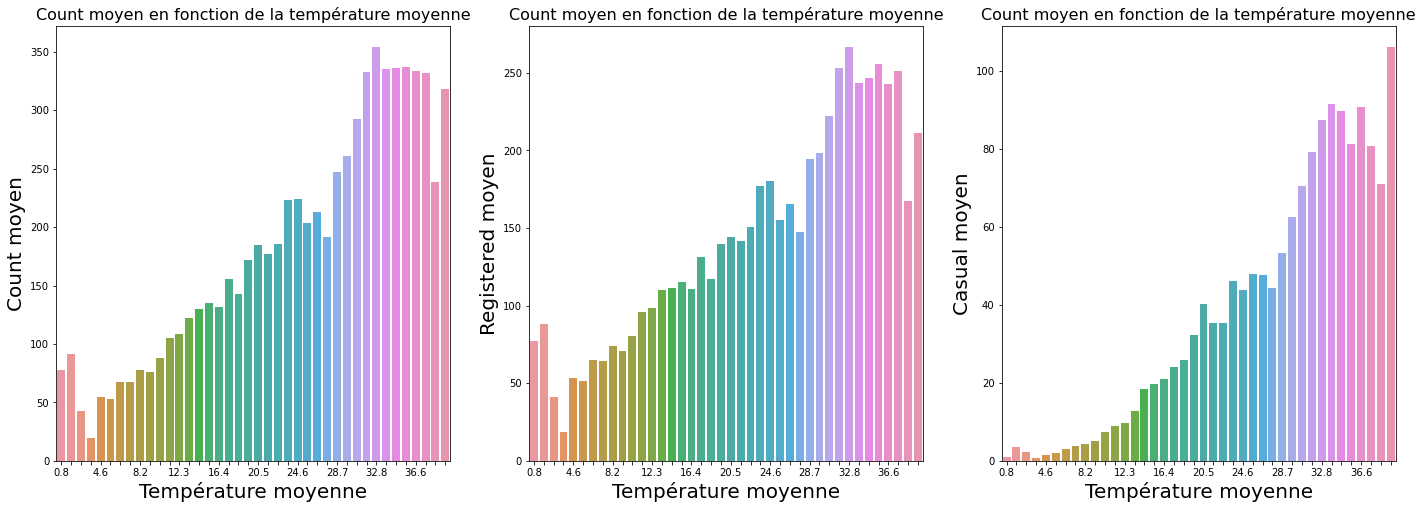

In [72]:
fig, ax = plt.subplots(1,3,figsize=(24,8))
p = sns.barplot(ax=ax[0], x='moyenne_temp',y='moyenne_count', data=temp_count)
reduce_xticks_number(p)
ax[0].set_title("Count moyen en fonction de la température moyenne",fontsize=16)
ax[0].set_xlabel('Température moyenne',fontsize=20)
ax[0].set_ylabel('Count moyen',fontsize=20)

p = sns.barplot(ax=ax[1], x='moyenne_temp',y='moyenne_registered', data=temp_registered)
reduce_xticks_number(p)
ax[1].set_title("Count moyen en fonction de la température moyenne",fontsize=16)
ax[1].set_xlabel('Température moyenne',fontsize=20)
ax[1].set_ylabel('Registered moyen',fontsize=20)

p = sns.barplot(ax=ax[2], x='moyenne_temp',y='moyenne_casual', data=temp_casual)
reduce_xticks_number(p)
ax[2].set_title("Count moyen en fonction de la température moyenne",fontsize=16)
ax[2].set_xlabel('Température moyenne',fontsize=20)
ax[2].set_ylabel('Casual moyen',fontsize=20)
plt.show()

### atemp

In [73]:
atemp_count = mean_cut(df_train,'atemp','count',1)
atemp_registered = mean_cut(df_train,'atemp','registered',1)
atemp_casual = mean_cut(df_train,'atemp','casual',1)

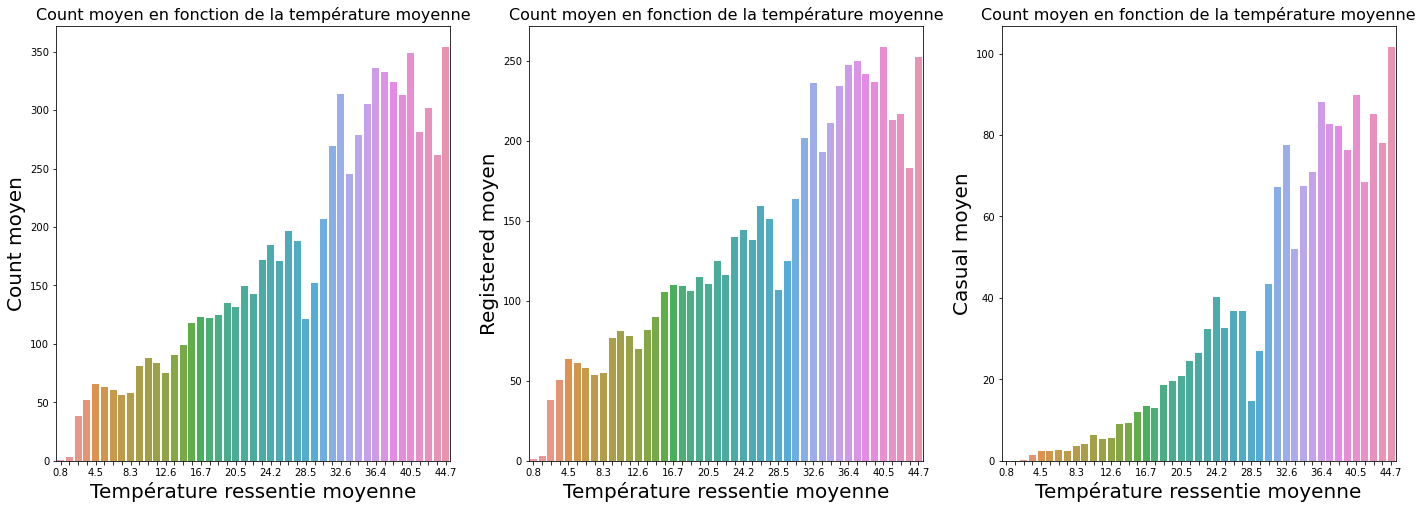

In [74]:
fig, ax = plt.subplots(1,3,figsize=(24,8))
p = sns.barplot(ax=ax[0], x='moyenne_atemp',y='moyenne_count', data=atemp_count)
reduce_xticks_number(p)
ax[0].set_title("Count moyen en fonction de la température moyenne",fontsize=16)
ax[0].set_xlabel('Température ressentie moyenne',fontsize=20)
ax[0].set_ylabel('Count moyen',fontsize=20)

p = sns.barplot(ax=ax[1], x='moyenne_atemp',y='moyenne_registered', data=atemp_registered)
reduce_xticks_number(p)
ax[1].set_title("Count moyen en fonction de la température moyenne",fontsize=16)
ax[1].set_xlabel('Température ressentie moyenne',fontsize=20)
ax[1].set_ylabel('Registered moyen',fontsize=20)

p = sns.barplot(ax=ax[2], x='moyenne_atemp',y='moyenne_casual', data=atemp_casual)
reduce_xticks_number(p)
ax[2].set_title("Count moyen en fonction de la température moyenne",fontsize=16)
ax[2].set_xlabel('Température ressentie moyenne',fontsize=20)
ax[2].set_ylabel('Casual moyen',fontsize=20)
plt.show()

### humidity

In [75]:
humidity_count = df_train.groupby('humidity')['count'].mean().reset_index()
humidity_registered = df_train.groupby('humidity')['registered'].mean().reset_index()
humidity_casual = df_train.groupby('humidity')['casual'].mean().reset_index()

Text(0, 0.5, 'Casual moyen')

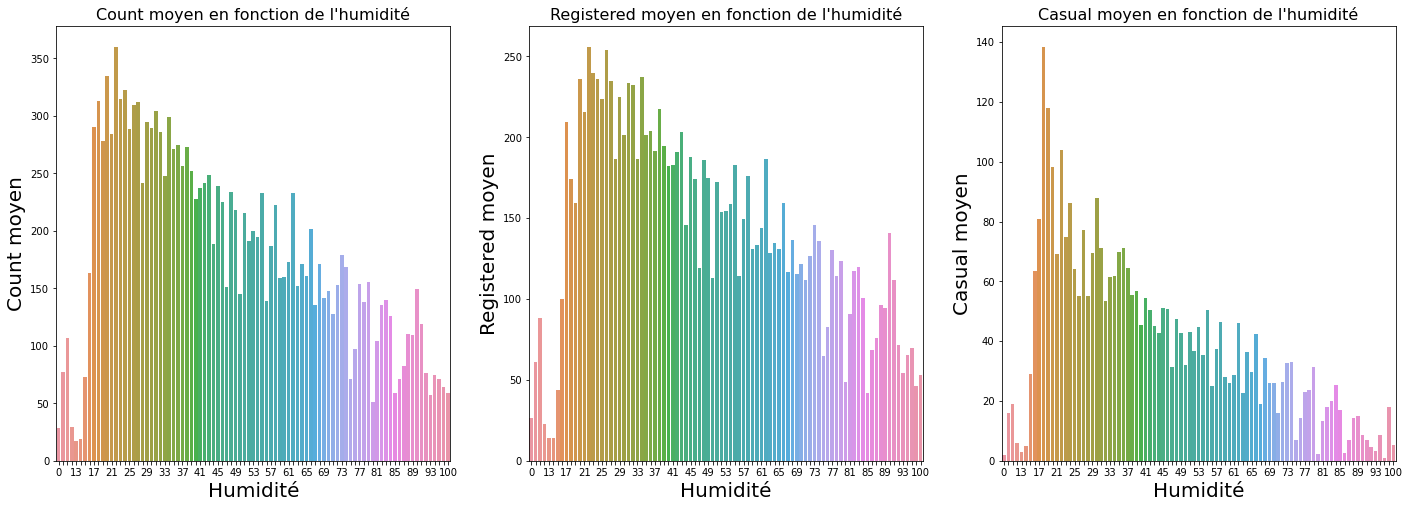

In [76]:
fig, ax = plt.subplots(1,3,figsize=(24,8))
p = sns.barplot(ax=ax[0], x='humidity',y='count', data=humidity_count)
reduce_xticks_number(p)
ax[0].set_title("Count moyen en fonction de l\'humidité",fontsize=16)
ax[0].set_xlabel('Humidité',fontsize=20)
ax[0].set_ylabel('Count moyen',fontsize=20)

p = sns.barplot(ax=ax[1], x='humidity',y='registered', data=humidity_registered)
reduce_xticks_number(p)
ax[1].set_title("Registered moyen en fonction de l\'humidité",fontsize=16)
ax[1].set_xlabel('Humidité',fontsize=20)
ax[1].set_ylabel('Registered moyen',fontsize=20)

p = sns.barplot(ax=ax[2], x='humidity',y='casual', data=humidity_casual)
reduce_xticks_number(p)
ax[2].set_title("Casual moyen en fonction de l\'humidité",fontsize=16)
ax[2].set_xlabel('Humidité',fontsize=20)
ax[2].set_ylabel('Casual moyen',fontsize=20)

### windspeed

In [77]:
windspeed_count = mean_cut(df_train,'windspeed','count',0.1)
windspeed_registered = mean_cut(df_train,'windspeed','registered',0.1)
windspeed_casual = mean_cut(df_train,'windspeed','casual',0.1)

Text(0, 0.5, 'Casual moyen')

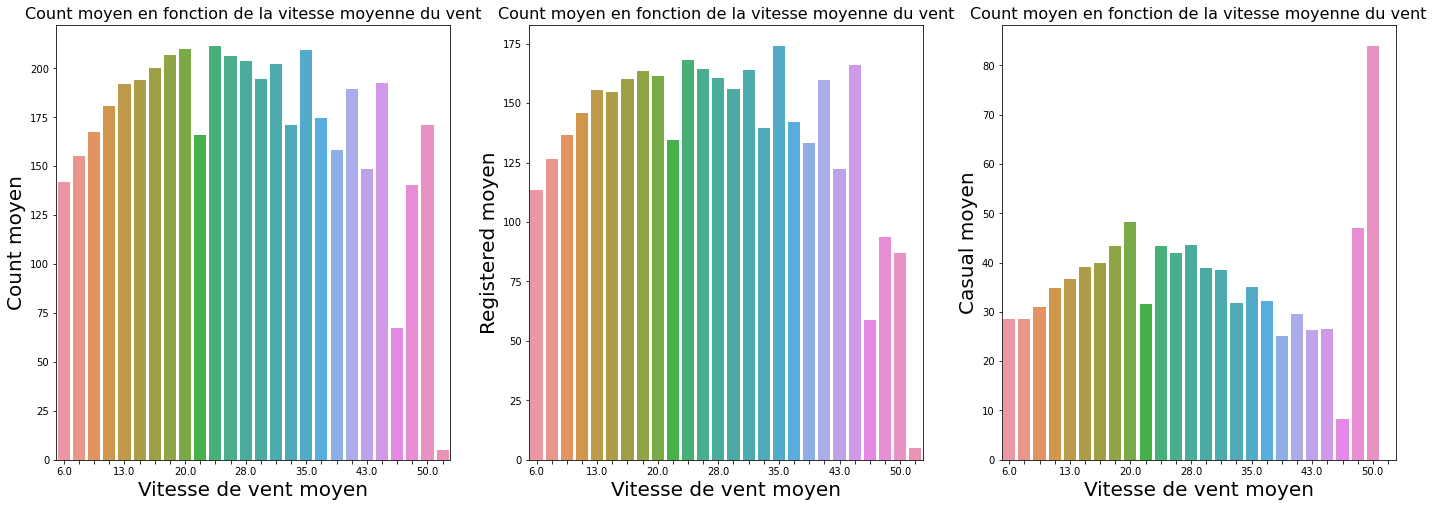

In [78]:
fig, ax = plt.subplots(1,3,figsize=(24,8))
p = sns.barplot(ax=ax[0], x='moyenne_windspeed',y='moyenne_count', data=windspeed_count)
reduce_xticks_number(p)
ax[0].set_title("Count moyen en fonction de la vitesse moyenne du vent",fontsize=16)
ax[0].set_xlabel('Vitesse de vent moyen',fontsize=20)
ax[0].set_ylabel('Count moyen',fontsize=20)

p = sns.barplot(ax=ax[1], x='moyenne_windspeed',y='moyenne_registered', data=windspeed_registered)
reduce_xticks_number(p)
ax[1].set_title("Count moyen en fonction de la vitesse moyenne du vent",fontsize=16)
ax[1].set_xlabel('Vitesse de vent moyen',fontsize=20)
ax[1].set_ylabel('Registered moyen',fontsize=20)

p = sns.barplot(ax=ax[2], x='moyenne_windspeed',y='moyenne_casual', data=windspeed_casual)
reduce_xticks_number(p)
ax[2].set_title("Count moyen en fonction de la vitesse moyenne du vent",fontsize=16)
ax[2].set_xlabel('Vitesse de vent moyen',fontsize=20)
ax[2].set_ylabel('Casual moyen',fontsize=20)

Text(0, 0.5, 'proportion')

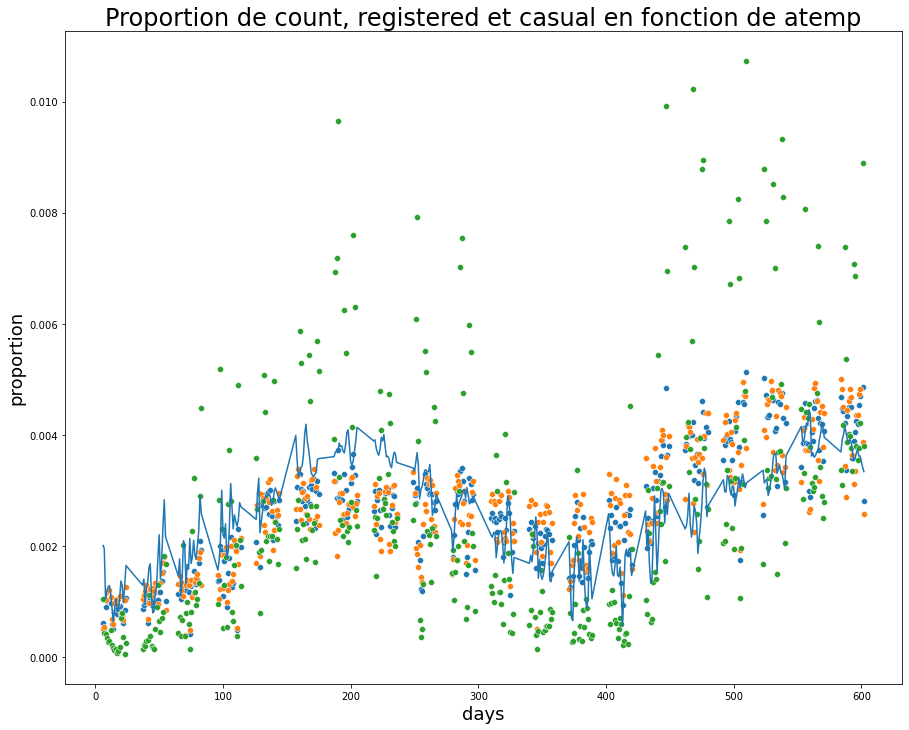

In [79]:
days_count = df_train.groupby('days')['count'].mean().reset_index()
days_count['count'] = days_count['count']/days_count['count'].sum()
days_registered = df_train.groupby('days')['registered'].mean().reset_index()
days_registered['registered'] = days_registered['registered']/days_registered['registered'].sum()
days_casual = df_train.groupby('days')['casual'].mean().reset_index()
days_casual['casual'] = days_casual['casual']/days_casual['casual'].sum()
colonne = 'atemp'
days_colonne = df_train.groupby('days')[colonne].mean().reset_index()
days_colonne[colonne] = days_colonne[colonne]/days_colonne[colonne].sum()
plt.figure(figsize=(15,12))
sns.scatterplot(x='days', y='count', data=days_count)
sns.scatterplot(x='days', y='registered', data=days_registered)
sns.scatterplot(x='days', y='casual', data=days_casual)
ax = sns.lineplot(x='days', y=colonne, data=days_colonne)
ax.set_title('Proportion de count, registered et casual en fonction de ' + colonne, fontsize=24)
ax.set_xlabel('days', fontsize=18)
ax.set_ylabel('proportion', fontsize=18)


In [80]:
df = df.drop(['datetime', 'dates', 'days'], axis=1)
df_train = df_train.drop(['datetime', 'dates', 'days'], axis=1)
df_test = df_test.drop(['datetime', 'dates', 'days'], axis=1)

In [81]:
df_train.to_csv('./csv/train_modifie_mickael.csv')
df_test.to_csv('./csv/test_modifie_mickael.csv')